In [1]:
import os, random
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.metrics import structural_similarity

Select 16 random directories from dataset. Read 1st image and target from each one using opencv

In [2]:
base_dir = '../data/nyu2_train'
random_dirs = random.sample(set(os.listdir(base_dir)), 16)
images, masks = [], []
for dir in random_dirs:
    img = cv2.imread(f'{base_dir}/{dir}/1.jpg')
    images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    mask = cv2.imread(f'{base_dir}/{dir}/1.png')
    masks.append(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY))

/var/folders/t5/ry1gbq2n2r7gk1_tvqx3d2p00000gn/T/ipykernel_31812/1814042367.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_dirs = random.sample(set(os.listdir(base_dir)), 16)


Load dinov2 model pre-trained on nyu dataset from Hugging Face and process inputs

In [3]:
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-base-nyu")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-base-nyu")

# prepare image for the model
inputs = image_processor(images=images, return_tensors="pt")

/Users/crountos/Desktop/interviews/depth_estimation/venv/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Get predictions

In [4]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

    # interpolate to original size
    preds = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=images[0].shape[:2],
        mode="bicubic",
        align_corners=False,
    )
preds.shape

torch.Size([16, 1, 480, 640])

Structural similarities between ground truth masks and predictions

In [5]:
def scale(arr):
    min_value, max_value = np.min(arr), np.max(arr)
    return (arr - min_value) / (max_value - min_value)

ssims = []
for pred, mask in zip(preds, masks):
    pred_n = pred.squeeze().numpy()
    pred_n = scale(pred_n)
    mask_n = scale(mask)
    ssims.append(structural_similarity(pred_n, mask_n, data_range=1.0))
ssims


[0.9166404692368666,
 0.9094100906096422,
 0.8795690216305271,
 0.886134978486806,
 0.7965045929934786,
 0.9018300257722347,
 0.8580277398871581,
 0.8948837686658406,
 0.8499510069174995,
 0.8472596724364426,
 0.8121142392231764,
 0.8178195475663983,
 0.9192201269922103,
 0.8476203864098011,
 0.8736705539694344,
 0.8855103325405903]

Plot target-prediction depth maps and the equivalent structural similarity scores

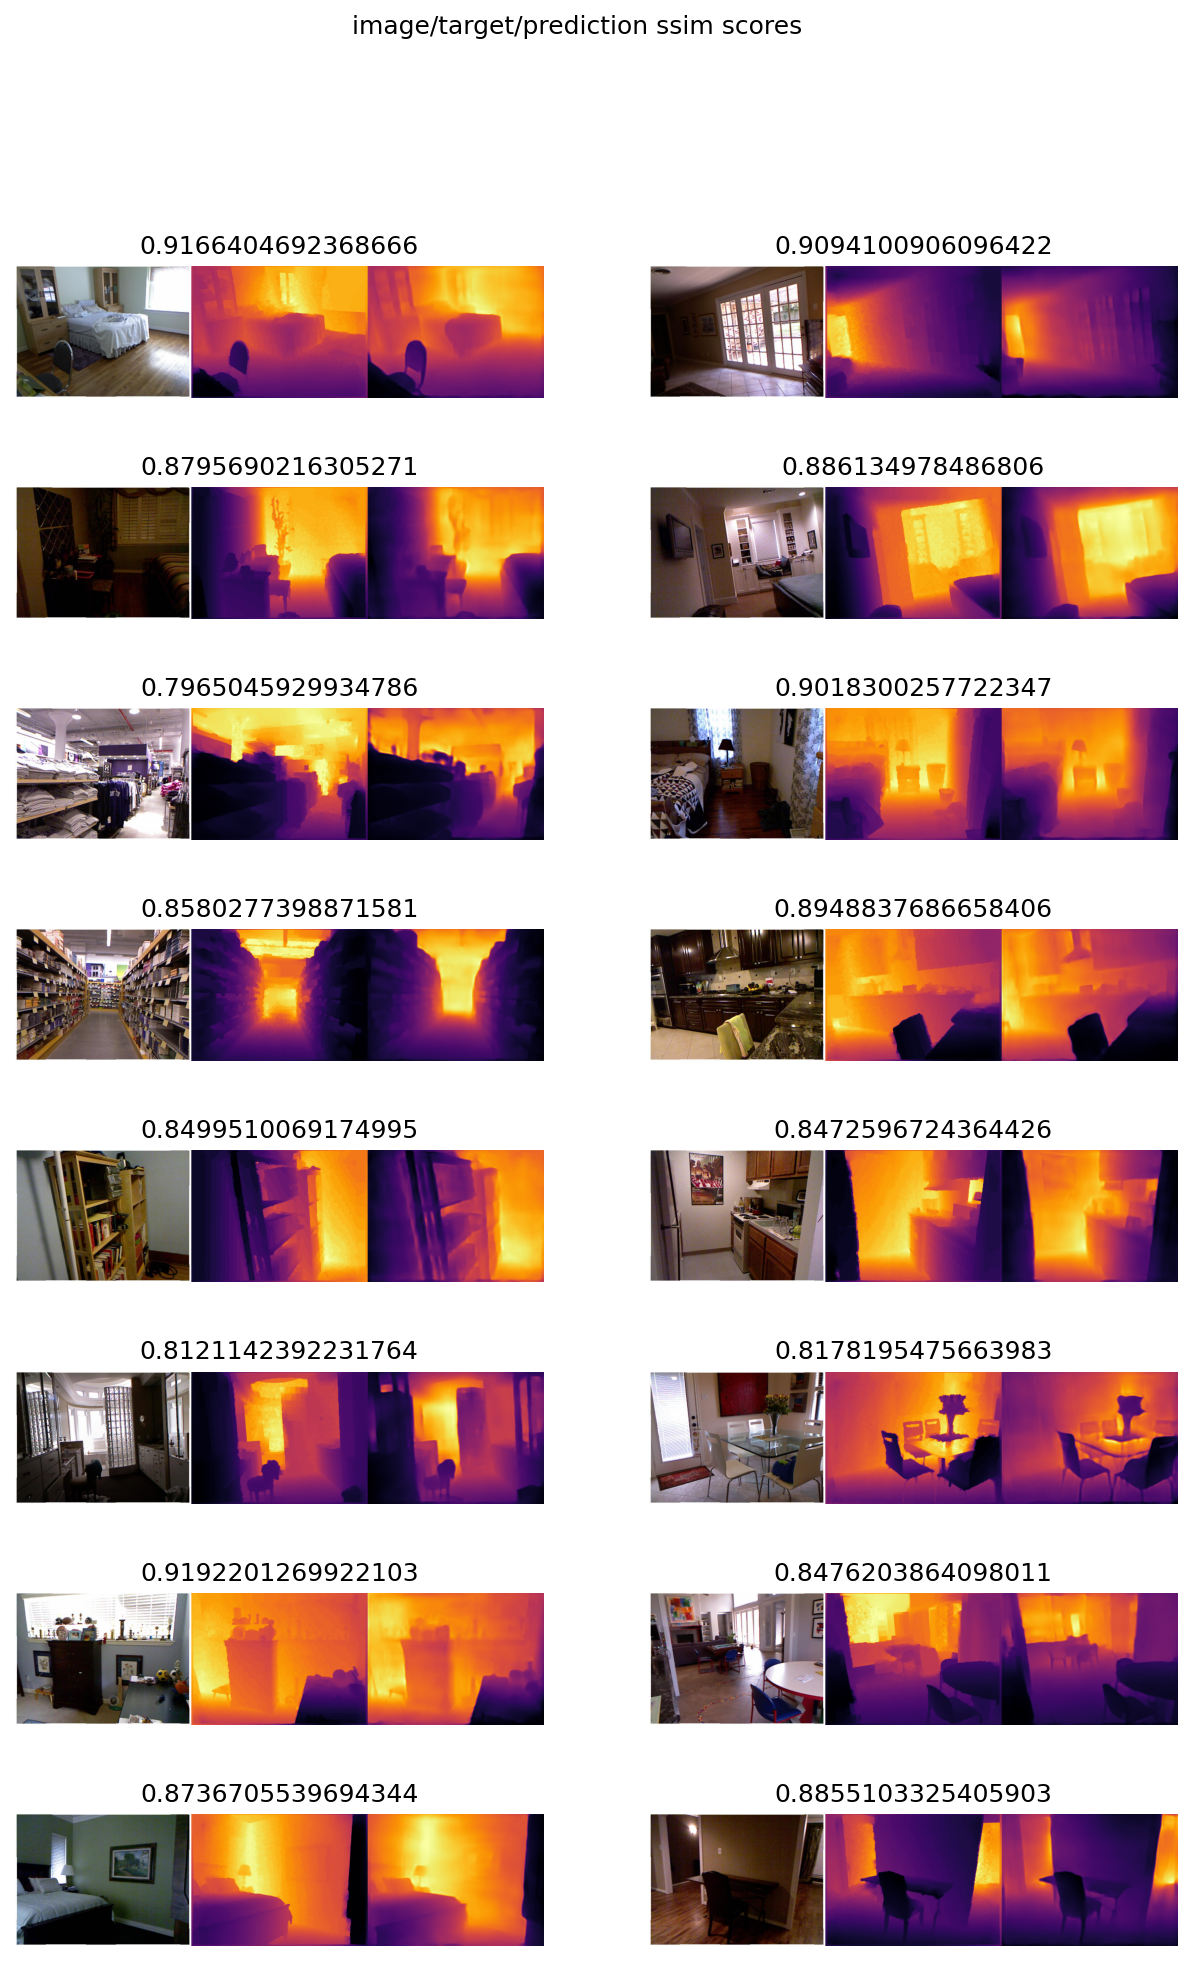

In [6]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3]

@torch.no_grad()
def plot_vals(imgs, targets, preds, ssims, n=1,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i in range(len(imgs)):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[i], preds[i], targets[i]
        pred = pred.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img, gt, pred])
        ax.title.set_text(f'{ssims[i]}')
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")

    plt.suptitle('image/target/prediction ssim scores')
    plt.show()
    

plot_vals(
        images,
        masks,
        preds.cpu(),
        ssims,
        n=16,
        figsize=(10, 15)
    )